In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import io
from IPython.display import Image
import pathlib
from tensorflow.keras import applications as ap
import re
import seaborn as sns
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# enable accelerated linear algebra
tf.config.optimizer.set_jit(True)
# enable tensorflow AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Load the TensorBoard notebook extension for training metrics graphs
%load_ext tensorboard


# Use small batches to allow current batch to fit in GPU memory for faster training
BATCH_SIZE = 4  
# Resizing the dataset images
IMAGE_SIDE = 150  
# Shuffling the images to ensure a better fit
SHUFFLE_SIZE = 25  
EPOCHS = 20  

# ensure we are in the correct working directory
os.chdir("/content")

# Local path to the dataset
DATASET_PATH = "/content/Pneumonia-detection-in-Chest-X-Ray-image-with-Deep-Learning/dataset"


**Download the dataset**

In [3]:
!git clone -b dataset https://github.com/etnikg/Pneumonia-detection-in-Chest-X-Ray-image-with-Deep-Learning.git

Cloning into 'Pneumonia-detection-in-Chest-X-Ray-image-with-Deep-Learning'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 5851 (delta 3), reused 5 (delta 0), pack-reused 5839
Receiving objects: 100% (5851/5851), 1.13 GiB | 43.17 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (5857/5857), done.


In [0]:
# Download a local copy of the dataset and then build paths 
# to the different dataset subsets: 'train', 'test', and 'validate'

dataset = pathlib.Path(DATASET_PATH)
test = dataset.joinpath("test")
test_count = len(list(test.glob('**/*.jpeg')))
train = dataset.joinpath("train")
train_count = len(list(train.glob('**/*.jpeg')))
validate = dataset.joinpath("validate")
validate_count = len(list(validate.glob('**/*.jpeg')))


**Preprocess the images in each directory before training**

In [0]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2, 
    shear_range=0.2,
    fill_mode='nearest')


In [6]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=str(train), 
    shuffle=True, 
    target_size=(IMAGE_SIDE, IMAGE_SIDE),
    class_mode='categorical')

Found 3747 images belonging to 2 classes.


In [0]:
test_image_generator = ImageDataGenerator(rescale=1./255)
 

In [8]:
test_data_gen = test_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=str(test), 
    target_size=(IMAGE_SIDE, IMAGE_SIDE),
    shuffle=True, 
    class_mode='categorical')

Found 1172 images belonging to 2 classes.


In [0]:
validate_image_generator = ImageDataGenerator(rescale=1./255)


In [10]:
validate_data_gen = validate_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=str(validate), 
    target_size=(IMAGE_SIDE, IMAGE_SIDE),
    class_mode='categorical',
    shuffle=True)

Found 937 images belonging to 2 classes.


**Create the prediction model**

In [0]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', 
            input_shape=(IMAGE_SIDE, IMAGE_SIDE, 3)),
    Conv2D(16, (3,3), padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32,(3,3), padding='same', activation='relu'),
    Conv2D(32,(3,3),padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64,(3,3), padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(96, (3,3),dilation_rate=(2, 2), padding='same', activation='relu'),
    Conv2D(96, (3,3),padding='valid', activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3),dilation_rate=(2, 2), padding='same', activation='relu'),
    Conv2D(128, (3,3),padding='valid', activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(80, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 64)        1

In [0]:
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy']) 


In [0]:
## some necessary function to simplify files count and visualization via bar plot

def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts

def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)


def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)

def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

**Dataset is divided in relation 80:20 for training/testing images**

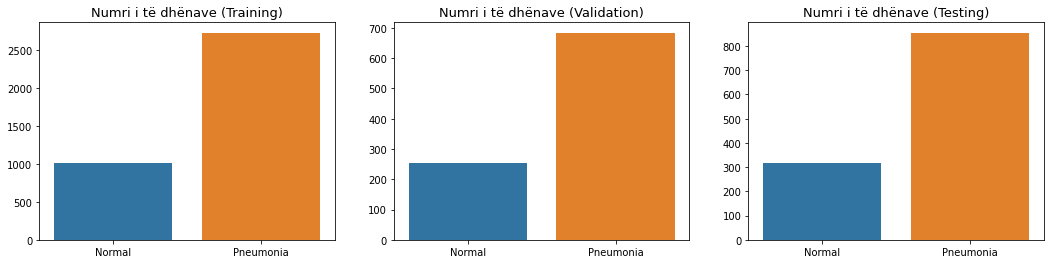

In [15]:

plot_params = {}
plot_params['figsize'] = (18,4)
plot_params["title"] = ""
plot_params["xlabel"] = ""
plot_params["ylabel"] = ""
plot_params["legends"] = []

plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10
plot_params["axes.titlesize"] = "small"
plot_params["image_file_name"] = ""

plot_params['title'] = "Numri i të dhënave"
plot_params["save"] = False
plot_params["update_image"] = True

plot_params['subplot'] = 131


plt.figure(figsize=plot_params['figsize'])

title = plot_params['title']
plot_params['title'] = title + " (Training)"
subplot_no = plot_params['subplot'] 



count_bar_plot(train, plot_params)

plot_params['title'] = title + " (Validation)"
plot_params['subplot'] = subplot_no+1
count_bar_plot(validate, plot_params)


plot_params['title'] = title + " (Testing)"
plot_params['subplot'] = subplot_no + 2
count_bar_plot(test, plot_params)

plt.show()
classes = os.listdir(train)
classes = [name_correct(i) for i in classes]

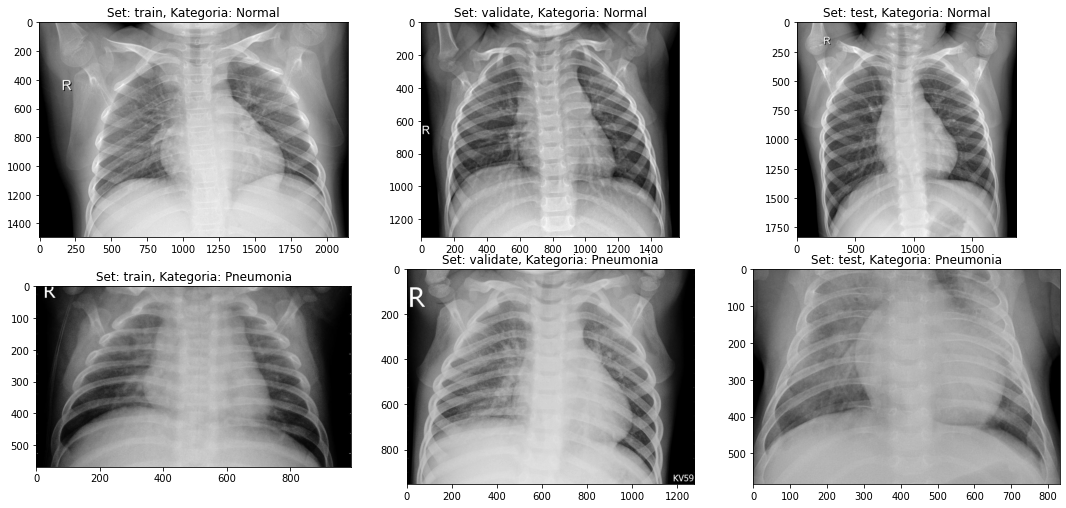

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'validate', 'test']):
    set_path = DATASET_PATH+'/'+_set
    ax[i].imshow(plt.imread('/'+set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Kategoria: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Kategoria: Pneumonia'.format(_set))

In [0]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Start training the model

In [18]:
history = model.fit(
      train_data_gen,        
      steps_per_epoch=train_count // BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=validate_data_gen,        
      validation_steps=validate_count // BATCH_SIZE,
      callbacks=[tensorboard_callback],
      use_multiprocessing=False,
) 

Epoch 1/20
936/936 [==============================] - 175s 187ms/step - loss: 0.5885 - accuracy: 0.7289 - val_loss: 0.5813 - val_accuracy: 0.7308
Epoch 2/20
936/936 [==============================] - 173s 185ms/step - loss: 0.5835 - accuracy: 0.7299 - val_loss: 0.5846 - val_accuracy: 0.7297
Epoch 3/20
936/936 [==============================] - 172s 184ms/step - loss: 0.5704 - accuracy: 0.7291 - val_loss: 0.5293 - val_accuracy: 0.7308
Epoch 4/20
936/936 [==============================] - 172s 184ms/step - loss: 0.4596 - accuracy: 0.7737 - val_loss: 0.4004 - val_accuracy: 0.7938
Epoch 5/20
936/936 [==============================] - 173s 185ms/step - loss: 0.3547 - accuracy: 0.8445 - val_loss: 0.2613 - val_accuracy: 0.9017
Epoch 6/20
936/936 [==============================] - 173s 185ms/step - loss: 0.3054 - accuracy: 0.8723 - val_loss: 0.3153 - val_accuracy: 0.8515
Epoch 7/20
936/936 [==============================] - 173s 185ms/step - loss: 0.2752 - accuracy: 0.8897 - val_loss: 0.2212 -

Save weights in a .h5 file

In [0]:

TMP_PATH = '/tmp/pneumonia_detection_model.h5'
model.save(TMP_PATH, overwrite=True, include_optimizer=True, save_format='h5')


In [20]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Visualize accuracy and loss graph over epochs

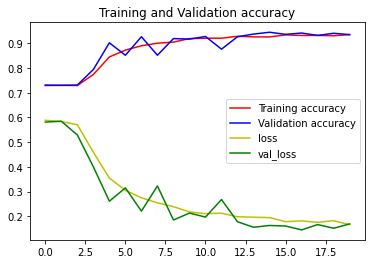

<Figure size 432x288 with 0 Axes>

In [21]:

acc = history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label='Training accuracy')
plt.plot(epochs,val_acc,'b',label='Validation accuracy')
plt.plot(epochs,loss,'y',label='loss')
plt.plot(epochs,val_loss,'g',label='val_loss')

plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

Evaluate model by tests images

In [22]:
print("results")
result  = model.evaluate_generator(test_data_gen, steps=len(test_data_gen), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
Instructions for updating:
Please use Model.evaluate, which supports generators.
293/293 [==============================] - 20s 67ms/step - loss: 0.1447 - accuracy: 0.9471
Loss     : 0.14  
Accuracy : 94.71%


In [23]:
print("results")
y_pred = model.predict_generator(test_data_gen, steps=len(test_data_gen), verbose=1)  



results
Instructions for updating:
Please use Model.predict, which supports generators.
293/293 [==============================] - 20s 67ms/step


In [24]:
y_pred = y_pred.argmax(axis=-1)
print(y_pred.shape)
y_true=test_data_gen.classes
print(y_true)

(1172,)
[0 0 0 ... 1 1 1]


**Precision, Recall and F1 score**

In [0]:
from sklearn.metrics import precision_score, recall_score,f1_score
precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 


print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")


